<a href="https://colab.research.google.com/github/amimulhasan/Deep-Learning/blob/main/u_net_mage_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# ------------------------
# CONFIG
# ------------------------
# Original Kaggle dataset path
DATA_DIR = "/kaggle/input/brain-tumor-classification-mri/Training"

# Working folder to store images and masks
WORK_DIR = "/kaggle/working/brain_tumor_seg_dataset"

IMG_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 40
NUM_CLASSES = 4
SEED = 42

IMAGES_DIR = os.path.join(WORK_DIR, "images")
MASKS_DIR  = os.path.join(WORK_DIR, "masks")

os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(MASKS_DIR, exist_ok=True)


2025-11-23 07:32:24.569768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763883144.751234      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763883144.804376      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [ ]:
# Copy images from Kaggle dataset to working folder
all_images = glob.glob(os.path.join(DATA_DIR, "*/*.jpg")) + glob.glob(os.path.join(DATA_DIR, "*/*.png"))

for i, img_path in enumerate(all_images):
    ext = os.path.splitext(img_path)[1]
    dest = os.path.join(IMAGES_DIR, f"{i:04d}{ext}")
    Image.open(img_path).convert("RGB").save(dest)

print(f"Total images copied: {len(os.listdir(IMAGES_DIR))}")


Total images copied: 2870


In [ ]:
# Create dummy masks for 4 classes (0=background, 1-3=tumor regions)
for img_name in tqdm(os.listdir(IMAGES_DIR)):
    mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
    for class_id in range(1, NUM_CLASSES):
        # Random rectangle region for class
        x0 = random.randint(0, IMG_SIZE//2)
        y0 = random.randint(0, IMG_SIZE//2)
        x1 = random.randint(IMG_SIZE//2, IMG_SIZE)
        y1 = random.randint(IMG_SIZE//2, IMG_SIZE)
        mask[y0:y1, x0:x1] = class_id
    # Clip values to NUM_CLASSES-1 to avoid out-of-bounds
    mask = np.clip(mask, 0, NUM_CLASSES-1)
    Image.fromarray(mask).save(os.path.join(MASKS_DIR, img_name))

print(f"Total masks created: {len(os.listdir(MASKS_DIR))}")


100%|██████████| 2870/2870 [00:00<00:00, 5065.05it/s]

Total masks created: 2870


In [ ]:
def list_pairs(images_dir, masks_dir):
    imgs = sorted(glob.glob(os.path.join(images_dir, "*")))
    masks = sorted(glob.glob(os.path.join(masks_dir, "*")))
    img_map = {os.path.basename(p): p for p in imgs}
    mask_map = {os.path.basename(p): p for p in masks}
    common = sorted(set(img_map.keys()) & set(mask_map.keys()))
    images = [img_map[n] for n in common]
    masks  = [mask_map[n] for n in common]
    return images, masks

images, masks = list_pairs(IMAGES_DIR, MASKS_DIR)
print(f"Found {len(images)} image-mask pairs")


Found 2870 image-mask pairs


In [ ]:
# Load masks as integer arrays and clip
mask_arrays = np.stack([
    np.clip(np.array(Image.open(m).resize((IMG_SIZE, IMG_SIZE), Image.NEAREST), dtype=np.int32), 0, NUM_CLASSES-1)
    for m in tqdm(masks)
], axis=0)

# One-hot encode masks
mask_onehot = np.eye(NUM_CLASSES, dtype=np.float32)[mask_arrays]
print("Mask arrays shape:", mask_onehot.shape)

# Load images and normalize
image_arrays = np.stack([
    np.array(Image.open(img).resize((IMG_SIZE, IMG_SIZE)), dtype=np.float32)/255.0
    for img in tqdm(images)
], axis=0)
print("Image arrays shape:", image_arrays.shape)


100%|██████████| 2870/2870 [00:00<00:00, 4202.07it/s]


Mask arrays shape: (2870, 128, 128, 4)


100%|██████████| 2870/2870 [00:10<00:00, 282.95it/s]


Image arrays shape: (2870, 128, 128, 3)


In [ ]:
N = len(image_arrays)
idx = np.arange(N)
np.random.seed(SEED)
np.random.shuffle(idx)
t = int(0.8 * N)
train_idx, val_idx = idx[:t], idx[t:]

x_train, y_train = image_arrays[train_idx], mask_onehot[train_idx]
x_val, y_val = image_arrays[val_idx], mask_onehot[val_idx]

print(f"Train samples: {len(x_train)}, Val samples: {len(x_val)}")


Train samples: 2296, Val samples: 574


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    return image, mask

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024, seed=SEED)
train_ds = train_ds.map(lambda a,b: (tf.cast(a, tf.float32), tf.cast(b, tf.float32)), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.map(lambda a,b: (tf.cast(a, tf.float32), tf.cast(b, tf.float32)), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


I0000 00:00:1763883208.288698      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2,2))(c)
    return c, p

def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, (2,2), strides=(2,2), padding='same')(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES, base_filters=32):
    inputs = layers.Input(shape=input_shape)
    c1, p1 = encoder_block(inputs, base_filters)
    c2, p2 = encoder_block(p1, base_filters*2)
    c3, p3 = encoder_block(p2, base_filters*4)
    c4, p4 = encoder_block(p3, base_filters*8)
    bn = conv_block(p4, base_filters*16)
    d4 = decoder_block(bn, c4, base_filters*8)
    d3 = decoder_block(d4, c3, base_filters*4)
    d2 = decoder_block(d3, c2, base_filters*2)
    d1 = decoder_block(d2, c1, base_filters)
    outputs = layers.Conv2D(num_classes, (1,1), activation='softmax')(d1)
    return models.Model(inputs, outputs)

model = build_unet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[

 Total params: 7,771,972 (29.65 MB)

 Trainable params: 7,766,084 (29.63 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
def dice_coef_per_class(y_true, y_pred, smooth=1e-6):
    axes = (1,2)
    intersection = K.sum(y_true * y_pred, axis=axes)
    denom = K.sum(y_true + y_pred, axis=axes)
    dice = (2. * intersection + smooth) / (denom + smooth)
    return dice

def mean_dice_loss(y_true, y_pred):
    return 1.0 - K.mean(dice_coef_per_class(y_true, y_pred))

def combined_loss(y_true, y_pred):
    cce = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
    return cce + 0.8 * mean_dice_loss(y_true, y_pred)

def mean_iou_metric(num_classes=NUM_CLASSES):
    m = tf.keras.metrics.MeanIoU(num_classes=num_classes)
    def mean_iou(y_true, y_pred):
        y_true_int = tf.argmax(y_true, axis=-1)
        y_pred_int = tf.argmax(y_pred, axis=-1)
        m.update_state(tf.reshape(y_true_int, [-1]), tf.reshape(y_pred_int, [-1]))
        return m.result()
    return mean_iou

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=combined_loss,
              metrics=[mean_iou_metric(NUM_CLASSES), 'accuracy'])


In [ ]:
callbacks = [
    ModelCheckpoint("unet_brain_tumor_best.h5", monitor='val_mean_iou', mode='max', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1, min_lr=1e-7),
    EarlyStopping(monitor='val_mean_iou', patience=10, mode='max', restore_best_weights=True, verbose=1)
]

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=callbacks)


Epoch 1/40


I0000 00:00:1763883226.204629     127 service.cc:148] XLA service 0x7b5578003950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763883226.205362     127 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763883227.897496     127 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/144 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.2667 - loss: 2.4315 - mean_iou: 0.1366

I0000 00:00:1763883238.626212     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.4701 - loss: 1.9339 - mean_iou: 0.2076
Epoch 1: val_mean_iou improved from -inf to 0.25094, saving model to unet_brain_tumor_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 49s 173ms/step - accuracy: 0.4706 - loss: 1.9326 - mean_iou: 0.2078 - val_accuracy: 0.5081 - val_loss: 1.7647 - val_mean_iou: 0.2509 - learning_rate: 1.0000e-04
Epoch 2/40
143/144 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6033 - loss: 1.5782 - mean_iou: 0.2475
Epoch 2: val_mean_iou improved from 0.25094 to 0.25780, saving model to unet_brain_tumor_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.6033 - loss: 1.5782 - mean_iou: 0.2475 - val_accuracy: 0.6191 - val_loss: 1.5760 - val_mean_iou: 0.2578 - learning_rate: 1.0000e-04
Epoch 3/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6141 - loss: 1.5417 - mean_iou: 0.2601
Epoch 3: val_mean_iou improved from 0.25780 to 0.26303, saving model to unet_brain_tumor_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.6141 - loss: 1.5417 - mean_iou: 0.2601 - val_accuracy: 0.6256 - val_loss: 1.5213 - val_mean_iou: 0.2630 - learning_rate: 1.0000e-04
Epoch 4/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6152 - loss: 1.5362 - mean_iou: 0.2636
Epoch 4: val_mean_iou improved from 0.26303 to 0.26474, saving model to unet_brain_tumor_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.6152 - loss: 1.5361 - mean_iou: 0.2636 - val_accuracy: 0.6253 - val_loss: 1.5190 - val_mean_iou: 0.2647 - learning_rate: 1.0000e-04
Epoch 5/40
143/144 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6207 - loss: 1.5179 - mean_iou: 0.2650
Epoch 5: val_mean_iou improved from 0.26474 to 0.26535, saving model to unet_brain_tumor_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.6207 - loss: 1.5179 - mean_iou: 0.2650 - val_accuracy: 0.6238 - val_loss: 1.5134 - val_mean_iou: 0.2654 - learning_rate: 1.0000e-04
Epoch 6/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6216 - loss: 1.5144 - mean_iou: 0.2655
Epoch 6: val_mean_iou improved from 0.26535 to 0.26561, saving model to unet_brain_tumor_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.6216 - loss: 1.5144 - mean_iou: 0.2655 - val_accuracy: 0.6254 - val_loss: 1.5016 - val_mean_iou: 0.2656 - learning_rate: 1.0000e-04
Epoch 7/40
143/144 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6212 - loss: 1.5100 - mean_iou: 0.2656
Epoch 7: val_mean_iou improved from 0.26561 to 0.26570, saving model to unet_brain_tumor_best.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.6212 - loss: 1.5099 - mean_iou: 0.2656 - val_accuracy: 0.6262 - val_loss: 1.5156 - val_mean_iou: 0.2657 - learning_rate: 1.0000e-04
Epoch 8/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6269 - loss: 1.4997 - mean_iou: 0.2658
Epoch 8: val_mean_iou did not improve from 0.26570
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.6269 - loss: 1.4997 - mean_iou: 0.2658 - val_accuracy: 0.6224 - val_loss: 1.5140 - val_mean_iou: 0.2656 - learning_rate: 1.0000e-04
Epoch 9/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6235 - loss: 1.4985 - mean_iou: 0.2655
Epoch 9: val_mean_iou did not improve from 0.26570
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.6235 - loss: 1.4985 - mean_iou: 0.2655 - val_accuracy: 0.6270 - val_loss: 1.4999 - val_mean_iou: 0.2655 - learning_rate: 1.0000e-04
Epoch 10/40
143/144 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6293 - loss: 1.4910 - mean_iou: 0.2655
Epoch 10: val_m

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


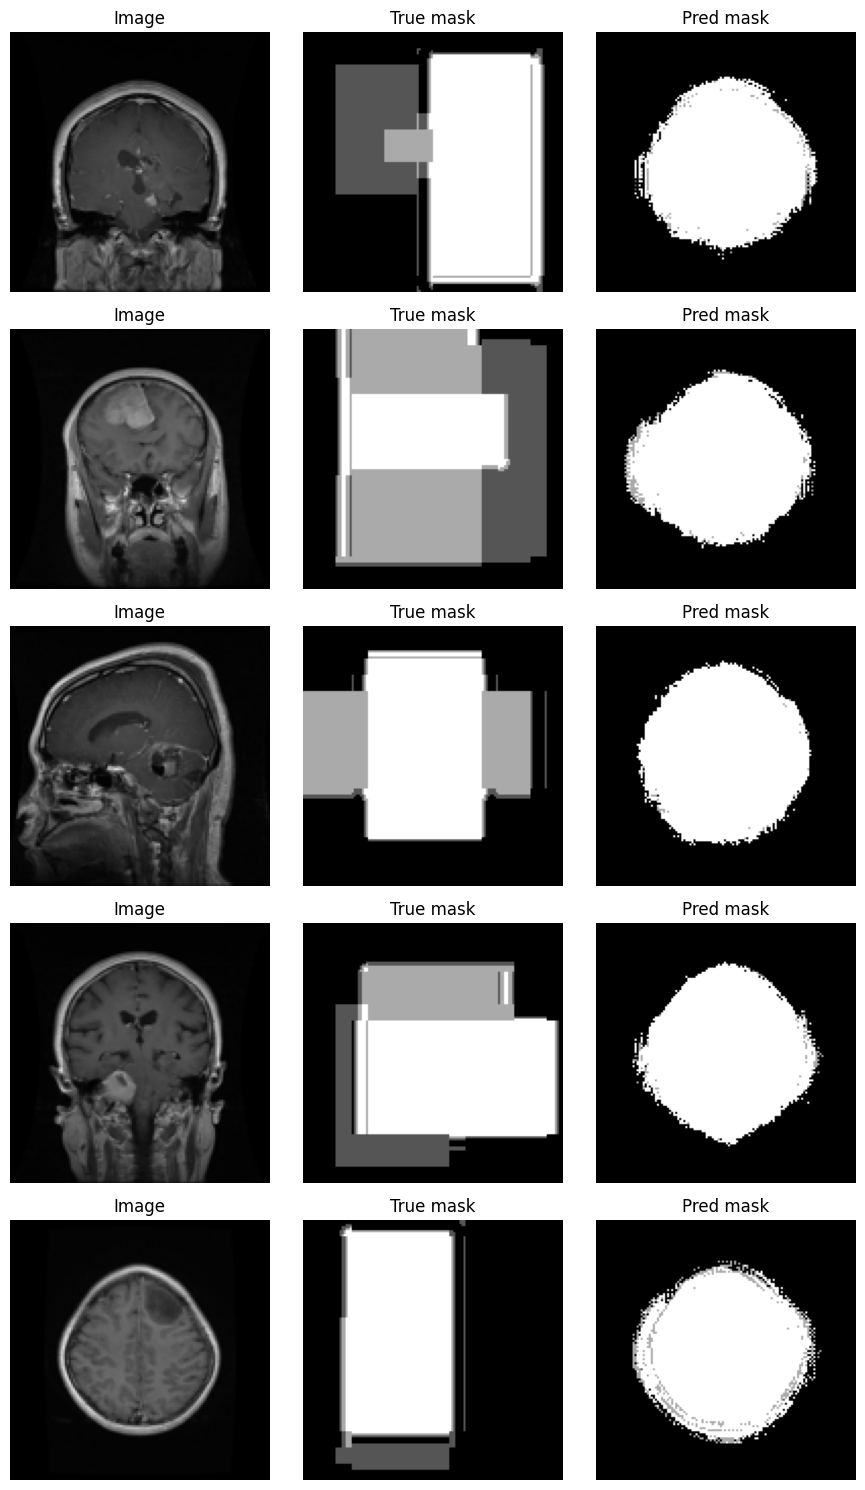

In [ ]:
model.save("unet_brain_tumor_final.h5")

def visualize_preds(n=5):
    ix = random.sample(range(len(x_val)), n)
    preds = model.predict(x_val[ix])
    preds_labels = np.argmax(preds, axis=-1)
    true_labels = np.argmax(y_val[ix], axis=-1)
    fig, axs = plt.subplots(n,3, figsize=(9,3*n))
    for i, idx_ in enumerate(ix):
        axs[i,0].imshow(x_val[idx_])
        axs[i,0].set_title("Image"); axs[i,0].axis('off')
        axs[i,1].imshow(true_labels[i], cmap='gray')
        axs[i,1].set_title("True mask"); axs[i,1].axis('off')
        axs[i,2].imshow(preds_labels[i], cmap='gray')
        axs[i,2].set_title("Pred mask"); axs[i,2].axis('off')
    plt.tight_layout()
    plt.show()

visualize_preds(5)
